In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import LSTM,Bidirectional
seed=42

In [4]:
df = pd.read_csv('final_oil_data.csv')
df['date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,Count_news,date
0,2019-04-02,69.209999,69.519997,68.690002,69.370003,69.370003,46166,-0.988166,-167,169,2019-04-02
1,2019-04-03,69.790001,69.959999,68.800003,69.309998,69.309998,46550,0.000000,0,2,2019-04-03
2,2019-04-04,69.489998,70.010002,68.879997,69.400002,69.400002,37531,-1.000000,-2,2,2019-04-04
3,2019-04-05,69.260002,70.470001,68.930000,70.339996,70.339996,36491,-1.000000,-2,2,2019-04-05
4,2019-04-08,70.500000,71.190002,70.440002,71.099998,71.099998,40966,-0.333333,-1,3,2019-04-08
...,...,...,...,...,...,...,...,...,...,...,...
1232,2024-08-26,79.320000,81.580002,79.239998,81.430000,81.430000,25997,-0.333333,-1,3,2024-08-26
1233,2024-08-27,81.220001,81.570000,79.480003,79.550003,79.550003,21261,0.000000,0,2,2024-08-27
1234,2024-08-28,79.839996,80.010002,77.930000,78.650002,78.650002,16512,1.000000,1,1,2024-08-28
1235,2024-08-30,79.519997,80.500000,78.599998,78.800003,78.800003,50268,-1.000000,-4,4,2024-08-30


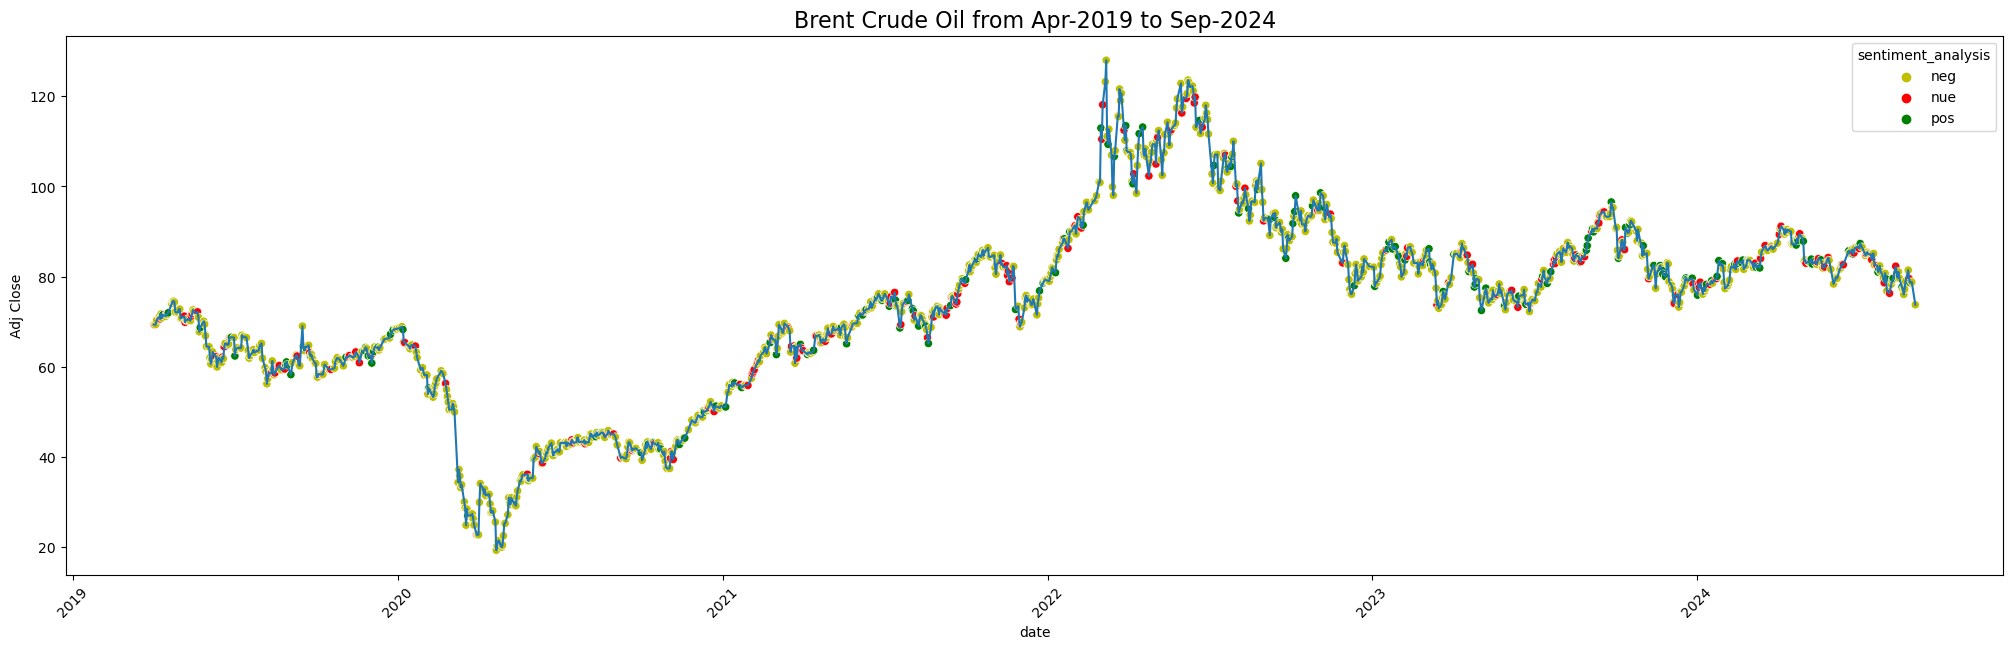

In [5]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Brent Crude Oil from Apr-2019 to Sep-2024",fontsize=16);

In [6]:
df['sentiment_analysis'].value_counts()

neg    845
pos    204
nue    188
Name: sentiment_analysis, dtype: int64

In [7]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,Count_news,date,sentiment_analysis
14,2019-04-23,74.199997,74.730003,73.989998,74.510002,74.510002,50165,-1.000000,-2,2,2019-04-23,neg
15,2019-04-24,74.320000,74.720001,74.000000,74.570000,74.570000,46326,-1.000000,-3,3,2019-04-24,neg
16,2019-04-25,74.529999,75.589996,74.000000,74.349998,74.349998,62237,-1.000000,-2,2,2019-04-25,neg
17,2019-04-26,74.300003,74.410004,71.290001,72.150002,72.150002,32803,-1.000000,-2,2,2019-04-26,neg
18,2019-04-29,71.699997,72.500000,71.110001,72.040001,72.040001,16694,-0.333333,-1,3,2019-04-29,neg
...,...,...,...,...,...,...,...,...,...,...,...,...
1232,2024-08-26,79.320000,81.580002,79.239998,81.430000,81.430000,25997,-0.333333,-1,3,2024-08-26,neg
1233,2024-08-27,81.220001,81.570000,79.480003,79.550003,79.550003,21261,0.000000,0,2,2024-08-27,nue
1234,2024-08-28,79.839996,80.010002,77.930000,78.650002,78.650002,16512,1.000000,1,1,2024-08-28,pos
1235,2024-08-30,79.519997,80.500000,78.599998,78.800003,78.800003,50268,-1.000000,-4,4,2024-08-30,neg


In [8]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2019-04-23,74.199997,74.730003,73.989998,74.510002,50165.0,74.510002,-1.000000
2019-04-24,74.320000,74.720001,74.000000,74.570000,46326.0,74.570000,-1.000000
2019-04-25,74.529999,75.589996,74.000000,74.349998,62237.0,74.349998,-1.000000
2019-04-26,74.300003,74.410004,71.290001,72.150002,32803.0,72.150002,-1.000000
2019-04-29,71.699997,72.500000,71.110001,72.040001,16694.0,72.040001,-0.333333
...,...,...,...,...,...,...,...
2024-08-26,79.320000,81.580002,79.239998,81.430000,25997.0,81.430000,-0.333333
2024-08-27,81.220001,81.570000,79.480003,79.550003,21261.0,79.550003,0.000000
2024-08-28,79.839996,80.010002,77.930000,78.650002,16512.0,78.650002,1.000000


In [9]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.49668206, 0.46193729, 0.54450702, ..., 0.57538567, 0.50786931,
        0.        ],
       [0.4977729 , 0.46185087, 0.54460094, ..., 0.53135287, 0.50842152,
        0.        ],
       [0.49968181, 0.46936832, 0.54460094, ..., 0.71384986, 0.50639666,
        0.        ],
       ...,
       [0.54795012, 0.50756072, 0.58150235, ..., 0.18939038, 0.54597331,
        1.        ],
       [0.5450413 , 0.51179469, 0.58779341, ..., 0.57656707, 0.5473539 ,
        0.        ],
       [0.5211344 , 0.48682278, 0.54009387, ..., 0.57656707, 0.50087435,
        0.        ]])

In [10]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1218, 5, 7).
TrainY shape = (1218, 1, 2).


In [11]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((974, 5, 6), (974, 5, 7))

In [12]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((876, 5, 6), (876, 5, 7))

In [13]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [14]:
# fit the model

cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )


history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 128)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 1, 512)            657408    
 al)                                                             
                                                        

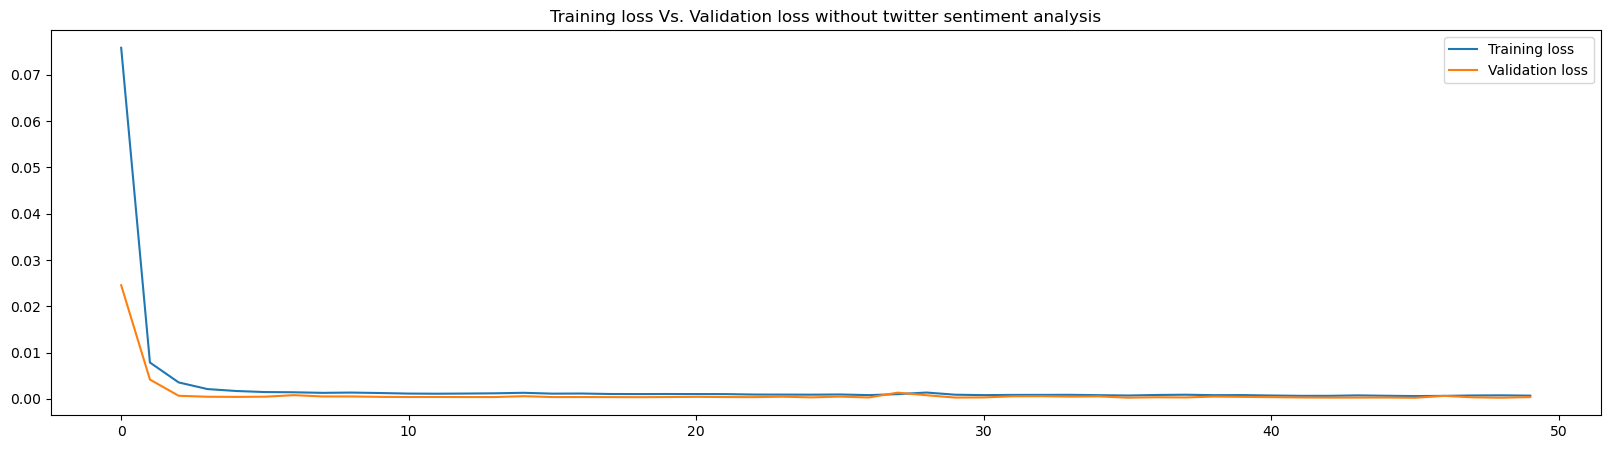

In [15]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

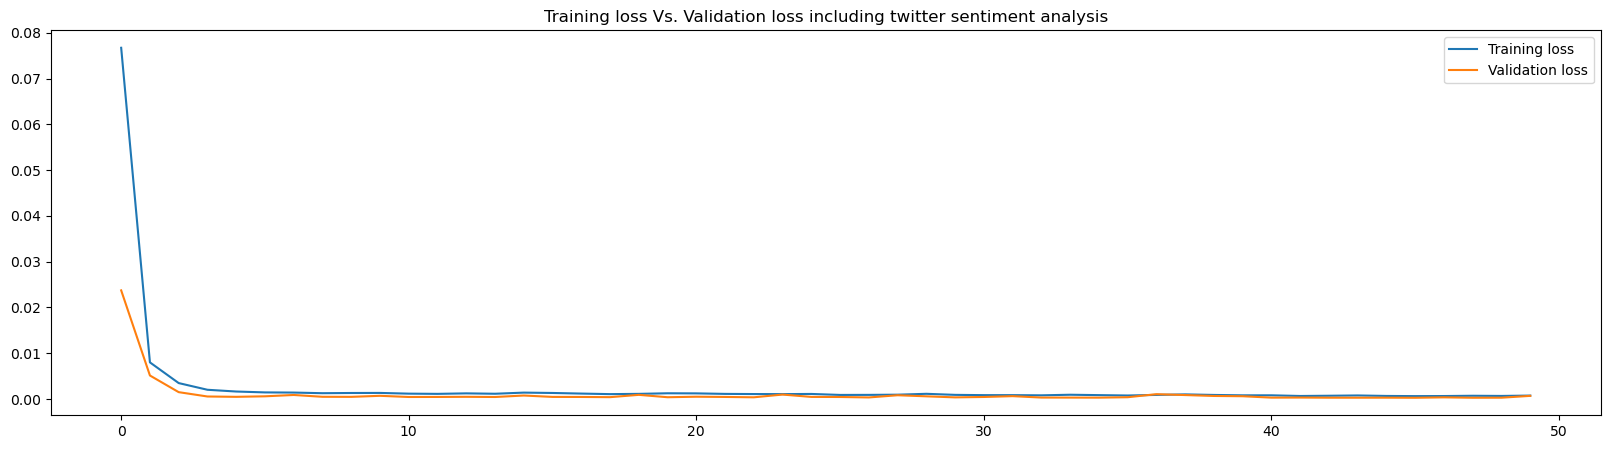

In [16]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

In [17]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [18]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

28/28 [==============================] - 0s 3ms/step


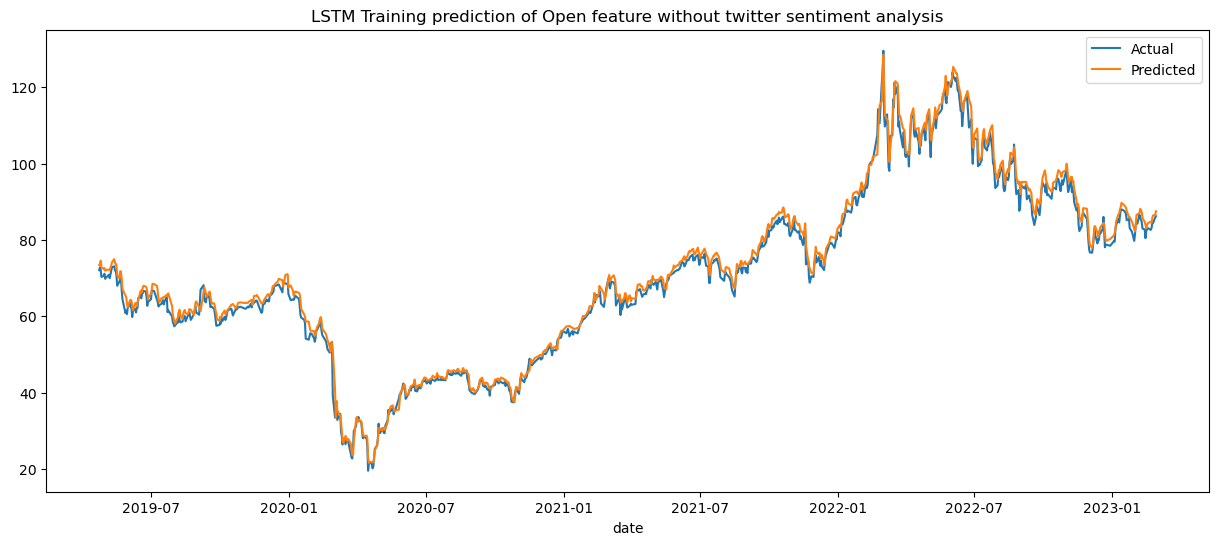

Mean square error for Open =4.332130190020718


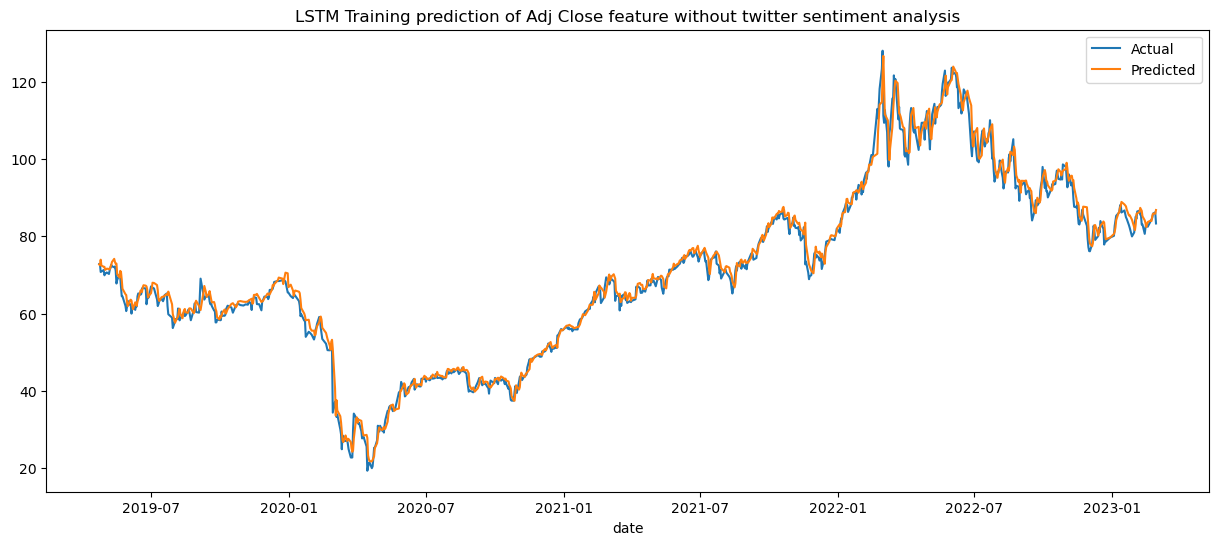

Mean square error for Adj Close =6.293326841801746
Total mean square error 5.312728515911235


In [19]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

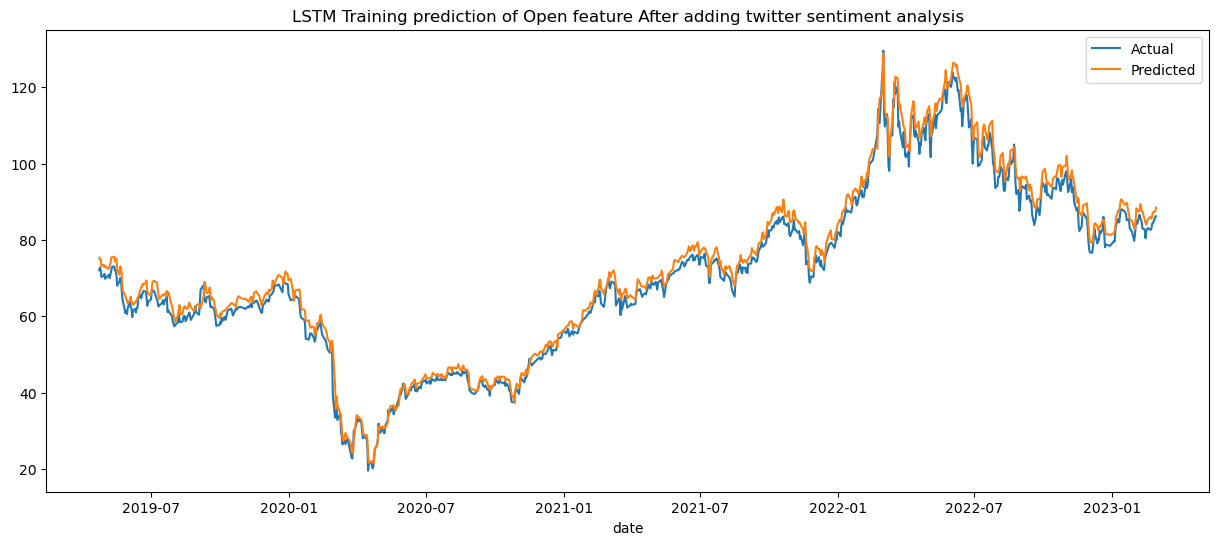

Mean square error for Open =7.8650517403641516


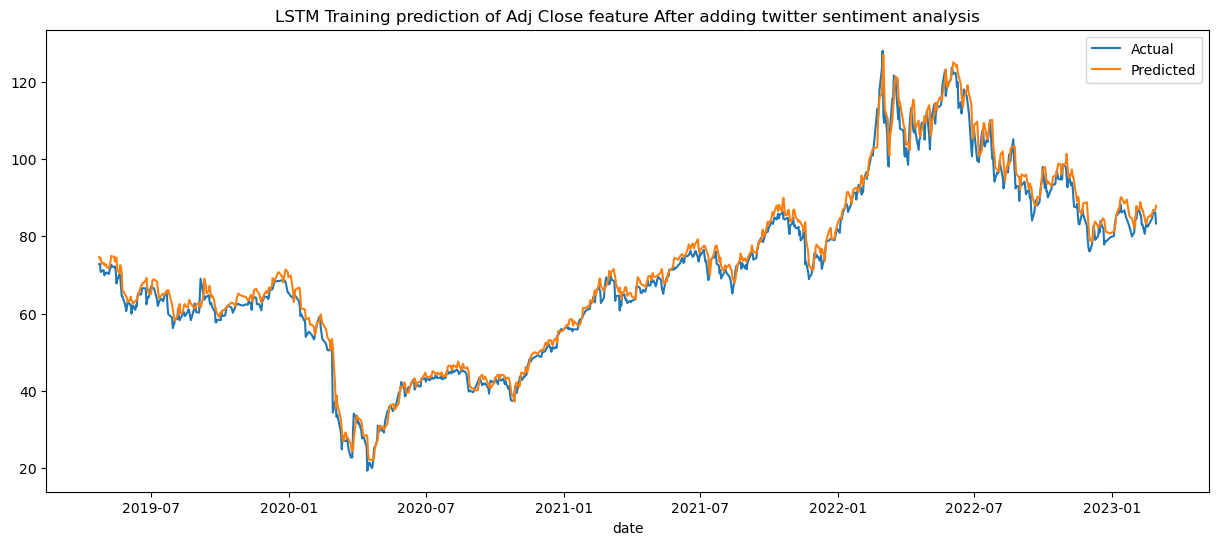

Mean square error for Adj Close =8.74315406816255
Total mean square error 8.304102904263356


In [20]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

In [21]:
validation_dates= df_for_training.index[X_train_lstm_without_twitter.shape[0]:X_train_lstm_without_twitter.shape[0] + X_val_lstm_without_twitter.shape[0]]
#Make prediction
validation_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_val_lstm_without_twitter)

validation_prediction_twitter = cnn_lstm_model_twitter.predict(X_val_lstm_twitter)

validation_prediction_without_twitter=validation_prediction_without_twitter.reshape(validation_prediction_without_twitter.shape[0], validation_prediction_without_twitter.shape[2])


validation_prediction_twitter=validation_prediction_twitter.reshape(validation_prediction_twitter.shape[0], validation_prediction_twitter.shape[2])


y_val_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(validation_prediction_without_twitter)
y_val_pred_lstm_twitter = scaler_for_inference.inverse_transform(validation_prediction_twitter)

y_val_actual_lstm_reshaped_without_twitter=y_val_lstm_without_twitter.reshape(y_val_lstm_without_twitter.shape[0], y_val_lstm_without_twitter.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_twitter)

4/4 [==============================] - 0s 3ms/step


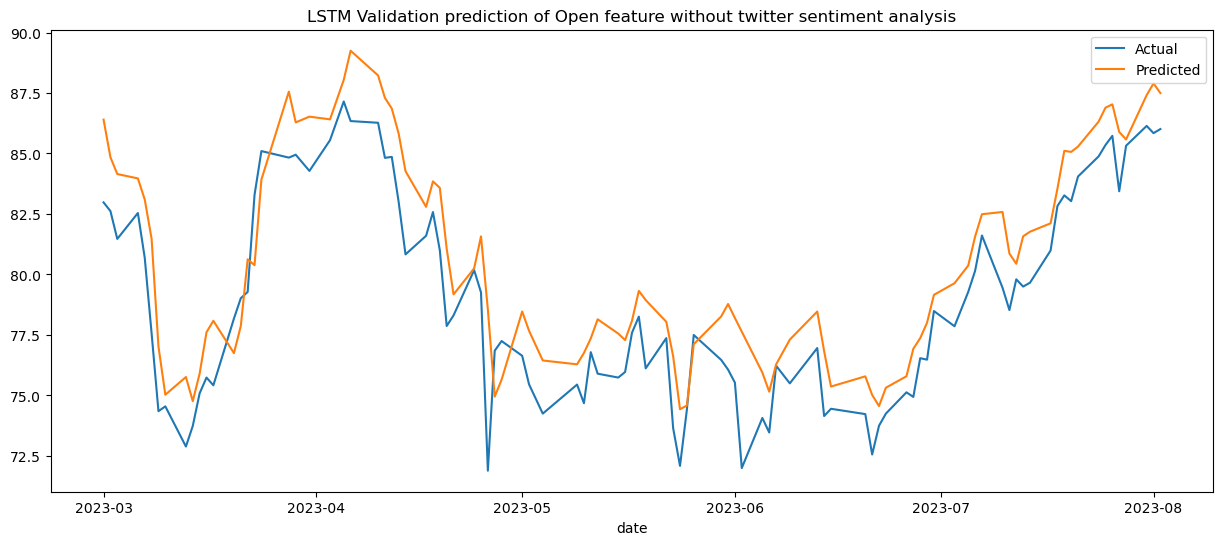

Mean square error for Open =4.3636756620336445


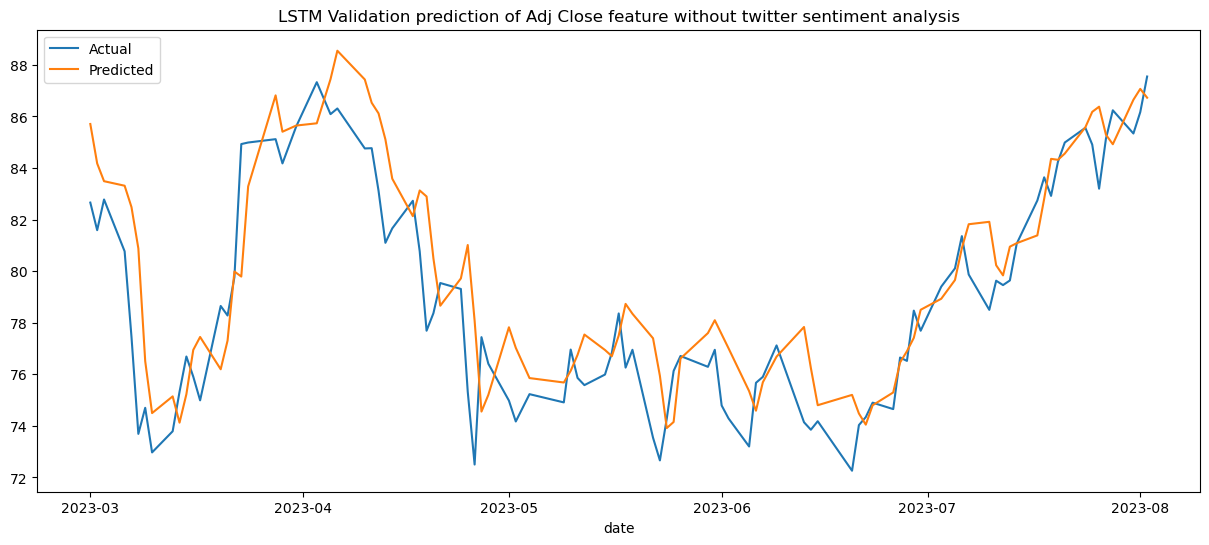

Mean square error for Adj Close =4.858096185766935
Total mean square error 4.610885923900289


In [22]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_twitter)

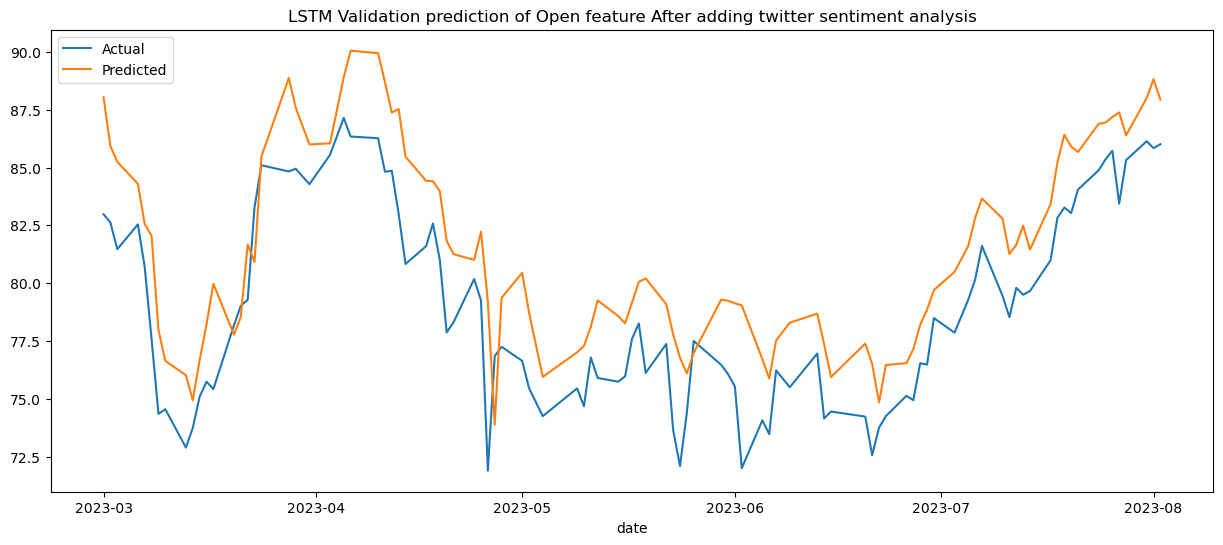

Mean square error for Open =8.347643795106608


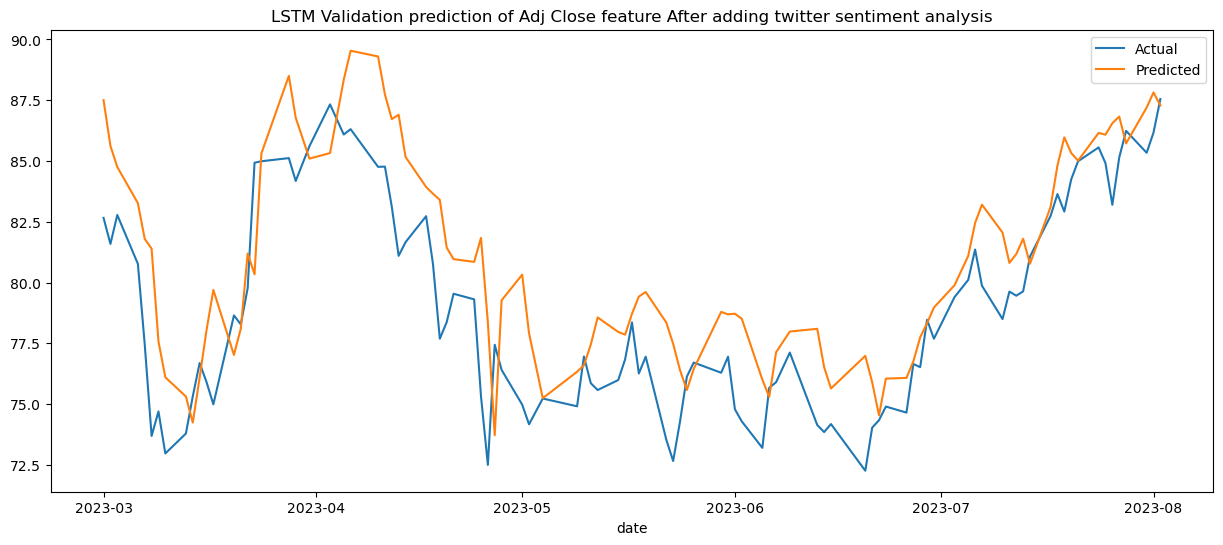

Mean square error for Adj Close =8.096862352064726
Total mean square error 8.222253073585666


In [23]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_twitter)

In [24]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

8/8 [==============================] - 0s 3ms/step


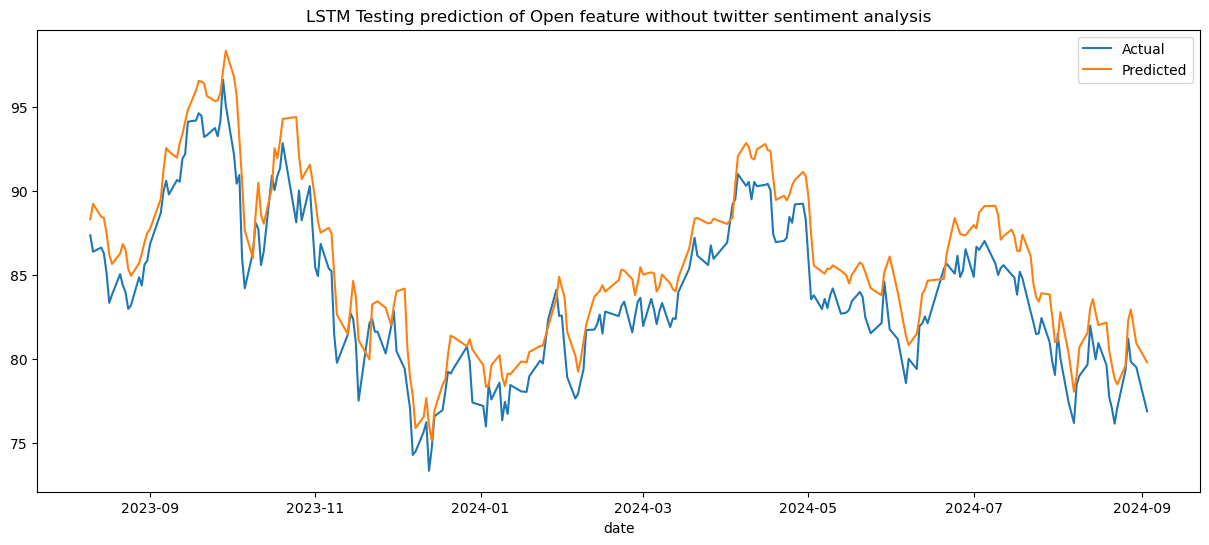

Mean square error for Open =4.846442389876851


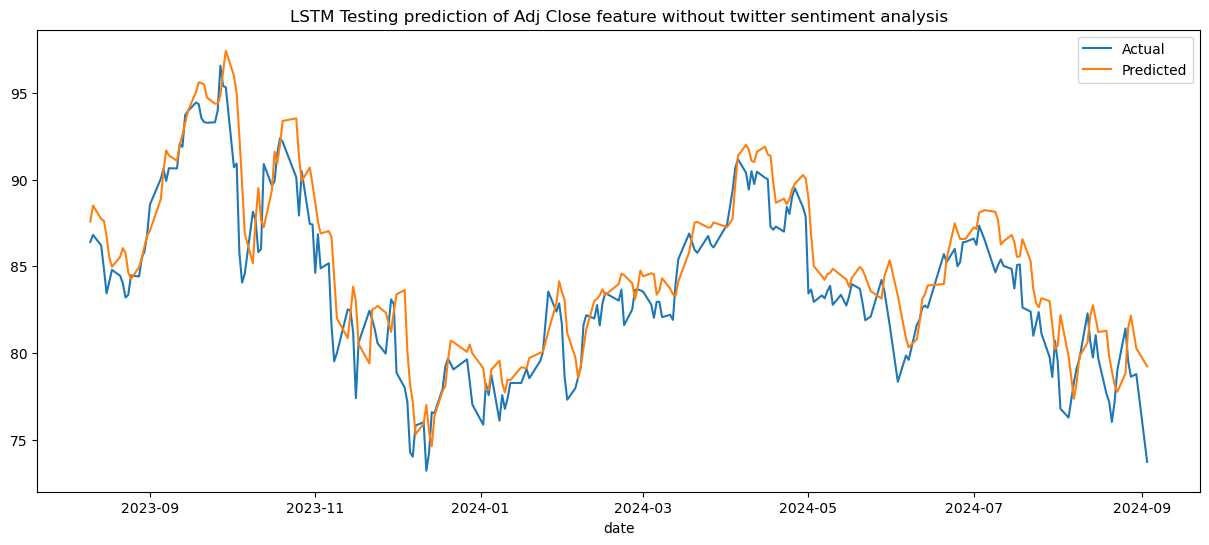

Mean square error for Adj Close =4.52494491335934
Total mean square error 4.685693651618097


In [25]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

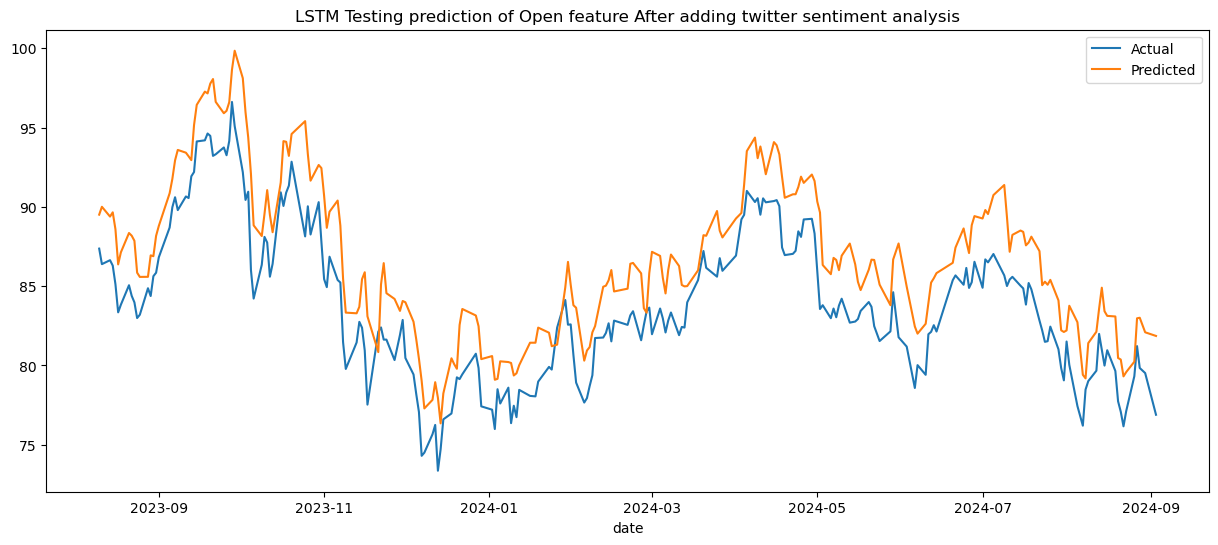

Mean square error for Open =10.163465627215023


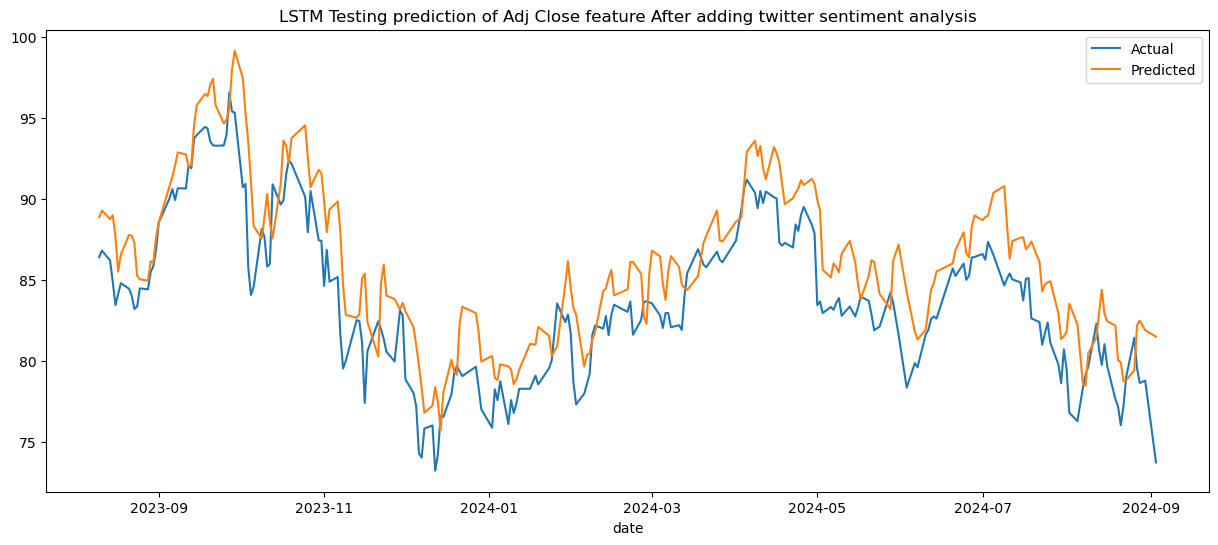

Mean square error for Adj Close =9.23722489508557
Total mean square error 9.700345261150304


In [26]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)